In [12]:
import os 
import glob
import numpy as np
import qim3d
import dask.array as da
import copy
from scipy import ndimage
from utils.utils_plot import viz_slices, viz_orthogonal_slices
from utils.utils_image import load_image
from utils.utils_preprocess import calc_histogram
from utils.utils_tiff import write_tiff
from skimage import filters, morphology, measure, segmentation, transform

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
def keep_largest_component(mask):
    # Label connected components
    labeled, num_features = ndimage.label(mask)
    if num_features == 0:
        return mask  # nothing found
    else:
        print(f"Number of components found: {num_features}")
    
    # Count size of each component (ignore background label 0)
    sizes = ndimage.sum(mask, labeled, range(1, num_features + 1))
    
    # Largest component index
    largest_label = np.argmax(sizes) + 1
    
    # Create mask for largest component
    return labeled == largest_label, num_features

In [ ]:
# Load image
base_path = "/work3/s173944/Python/projects/segmentation/data/image_volumes/"
image_path = "Femur_01_80kV_100W_cropped_scale_2.npy"
image_path = os.path.join(base_path, image_path)

slices = [100, 150, 250]

img = load_image(image_path)
viz_orthogonal_slices(img, slices, savefig=False)

In [ ]:
sobel_d = ndimage.sobel(img, 0) 
sobel_h = ndimage.sobel(img, 1) 
sobel_w = ndimage.sobel(img, 2) 
magnitude = np.sqrt(sobel_d**2 + sobel_h**2 + sobel_w**2)
magnitude *= 255.0 / np.max(magnitude)  # normalization

In [ ]:
# Load mask
base_path = "/work3/s173944/Python/projects/segmentation/data/predicted_volumes/"
mask_path = "Femur_01_80kV_100W_cropped_scale_2_1.npy" # "Vertebrae_D_4x_80kV_bin1_cropped_scale_4_1.npy" 
mask_path = os.path.join(base_path, mask_path)

mask = load_image(mask_path)
viz_orthogonal_slices(mask, slices, savefig=False)

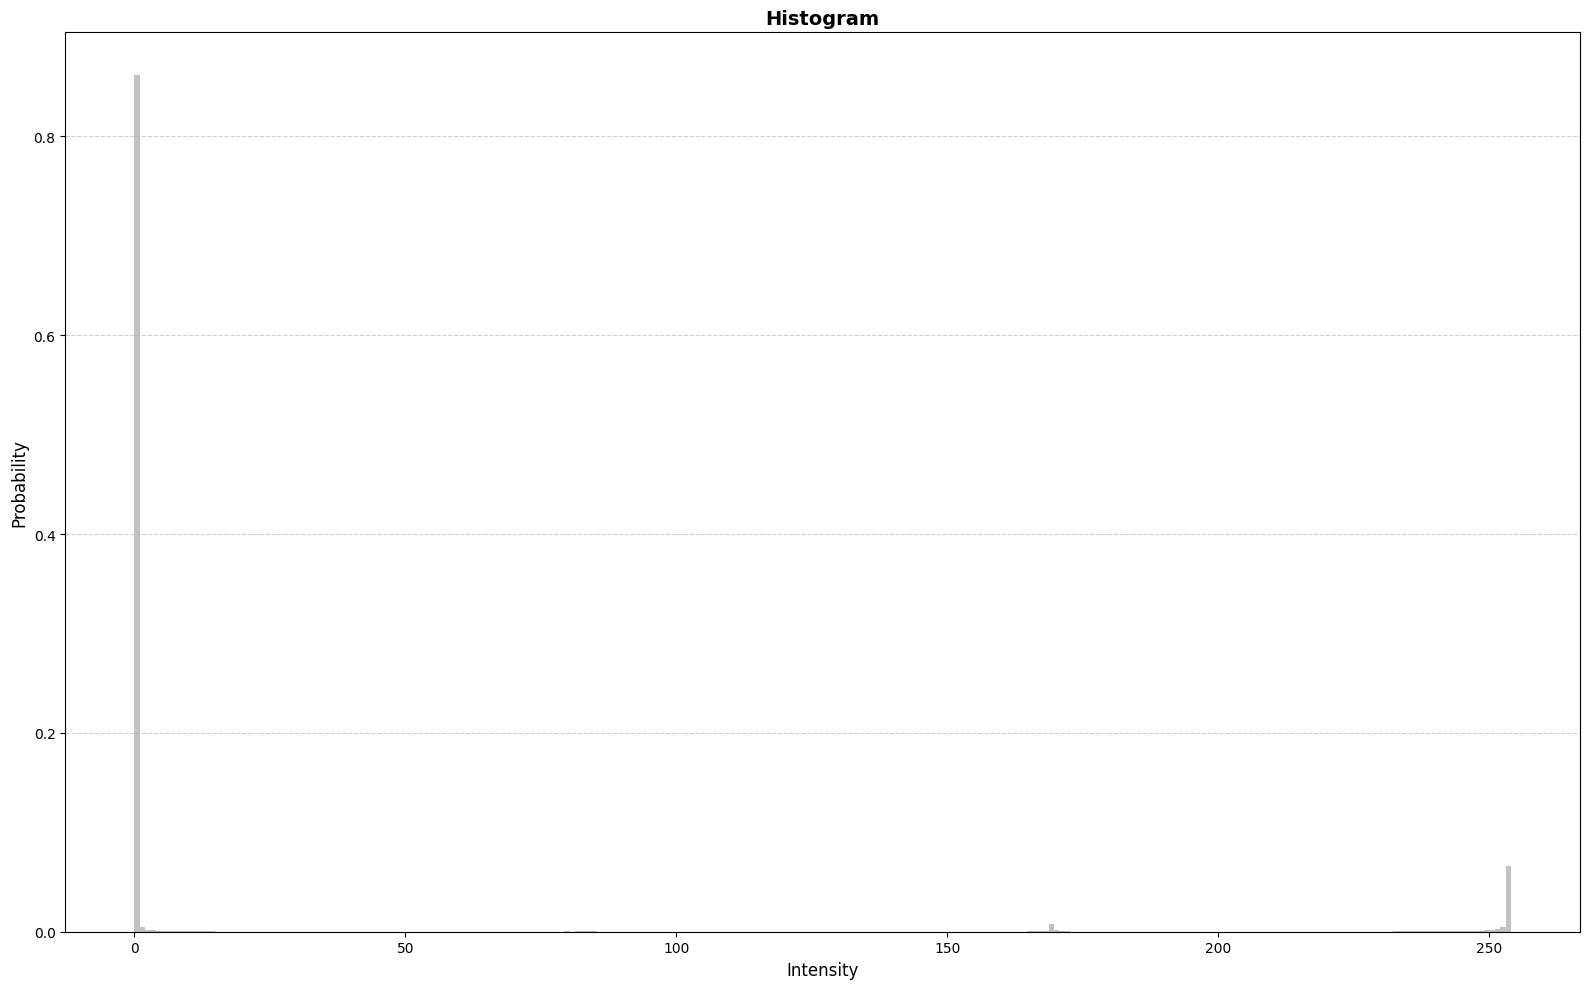

In [13]:
# Mask histogram
hist, bins = calc_histogram(mask, show_plot=True)


In [47]:
# viz_orthogonal_slices(magnitude, [100, 250, 400], savefig=False)

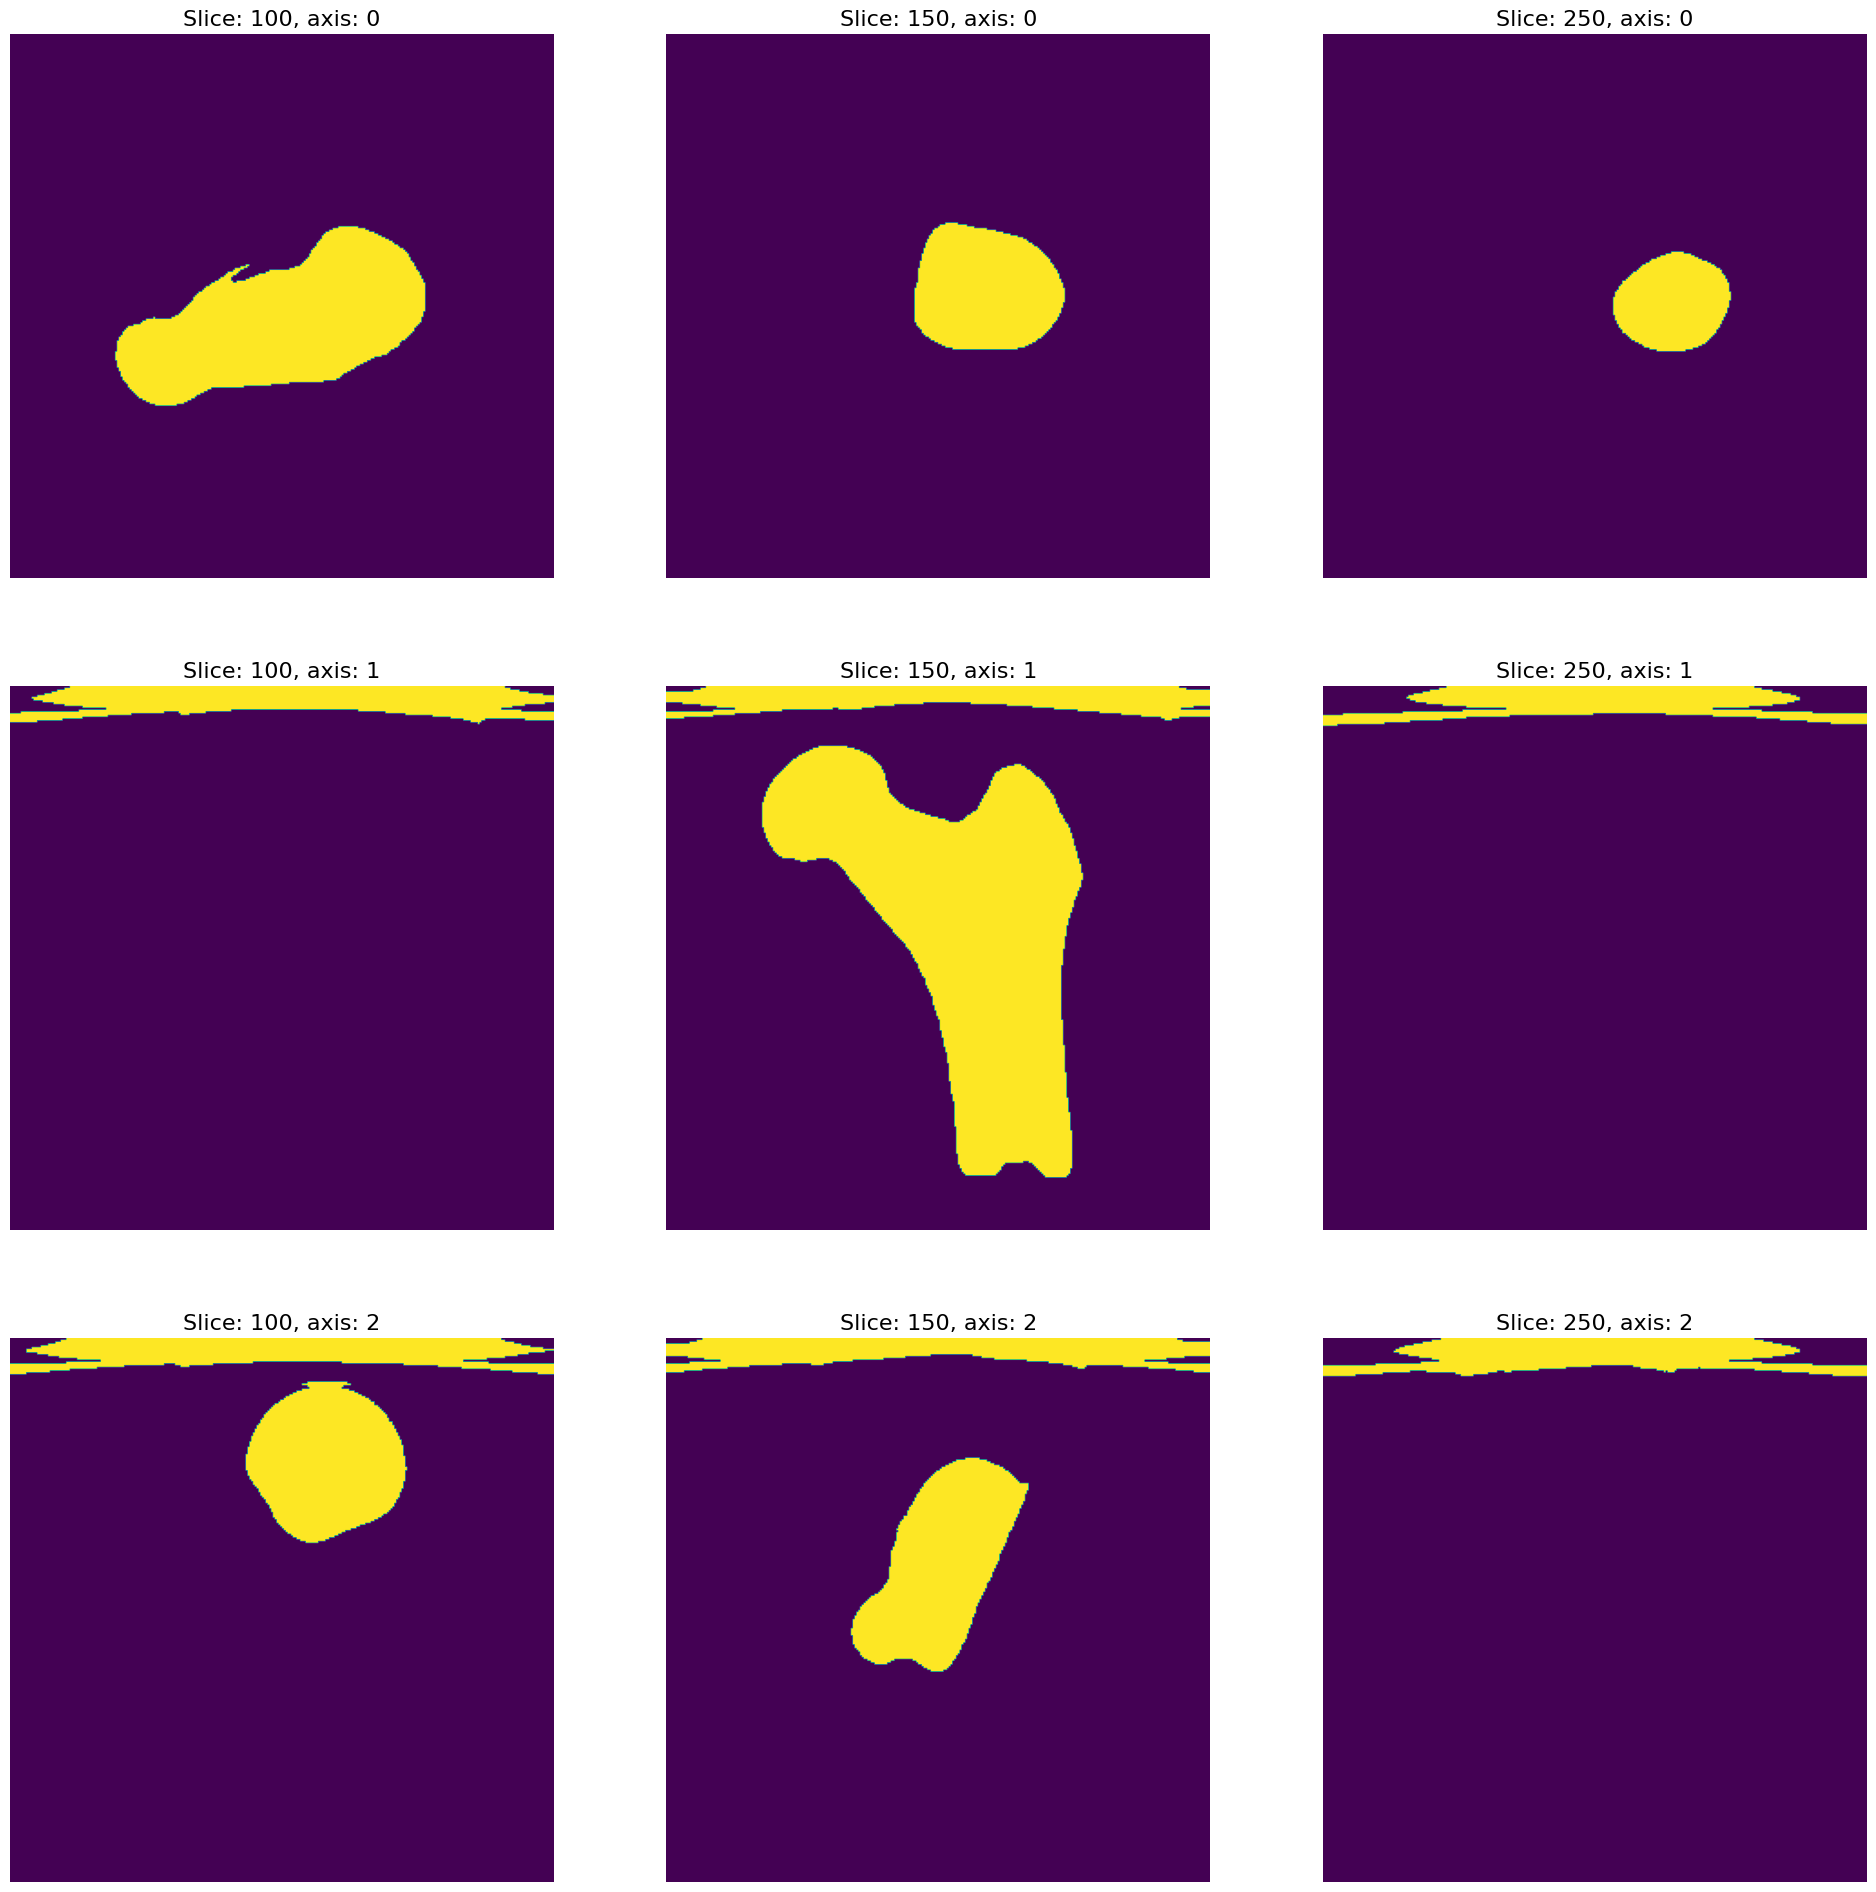

In [14]:
# Threshold
t = 225
mask = mask > t
viz_orthogonal_slices(mask, slices, savefig=False)


In [21]:
# Erosion to remove small objects
struct = ndimage.generate_binary_structure(*(3,3))
#mask_eroded = ndimage.binary_erosion(mask, structure=struct, iterations=1)
#mask_eroded = ndimage.binary_closing(mask, structure=struct, iterations=3)

# Filter based on number of connected components
mask_largest, num_components = keep_largest_component(mask_eroded)

#c = 1
#while num_components > 1:    
#    print("Eroding image")
#    mask = ndimage.binary_erosion(mask_largest, structure=struct, iterations=1)
#    mask_largest, num_components = keep_largest_component(mask)
    
print("Smoothing image / filling holes")
mask_smooth = filters.gaussian(mask_largest, sigma=1.5)
mask_thresh = mask_smooth > 0.75
mask_closed = ndimage.binary_fill_holes(mask_thresh, structure=struct)

print("Post-smoothing")
mask_closed = filters.gaussian(mask_closed, sigma=1.5)
mask_closed = mask_closed > 0.50
    

Number of components found: 2
Smoothing image / filling holes
Post-smoothing


In [22]:
mask_largest, num_components = keep_largest_component(mask_closed)

Number of components found: 1


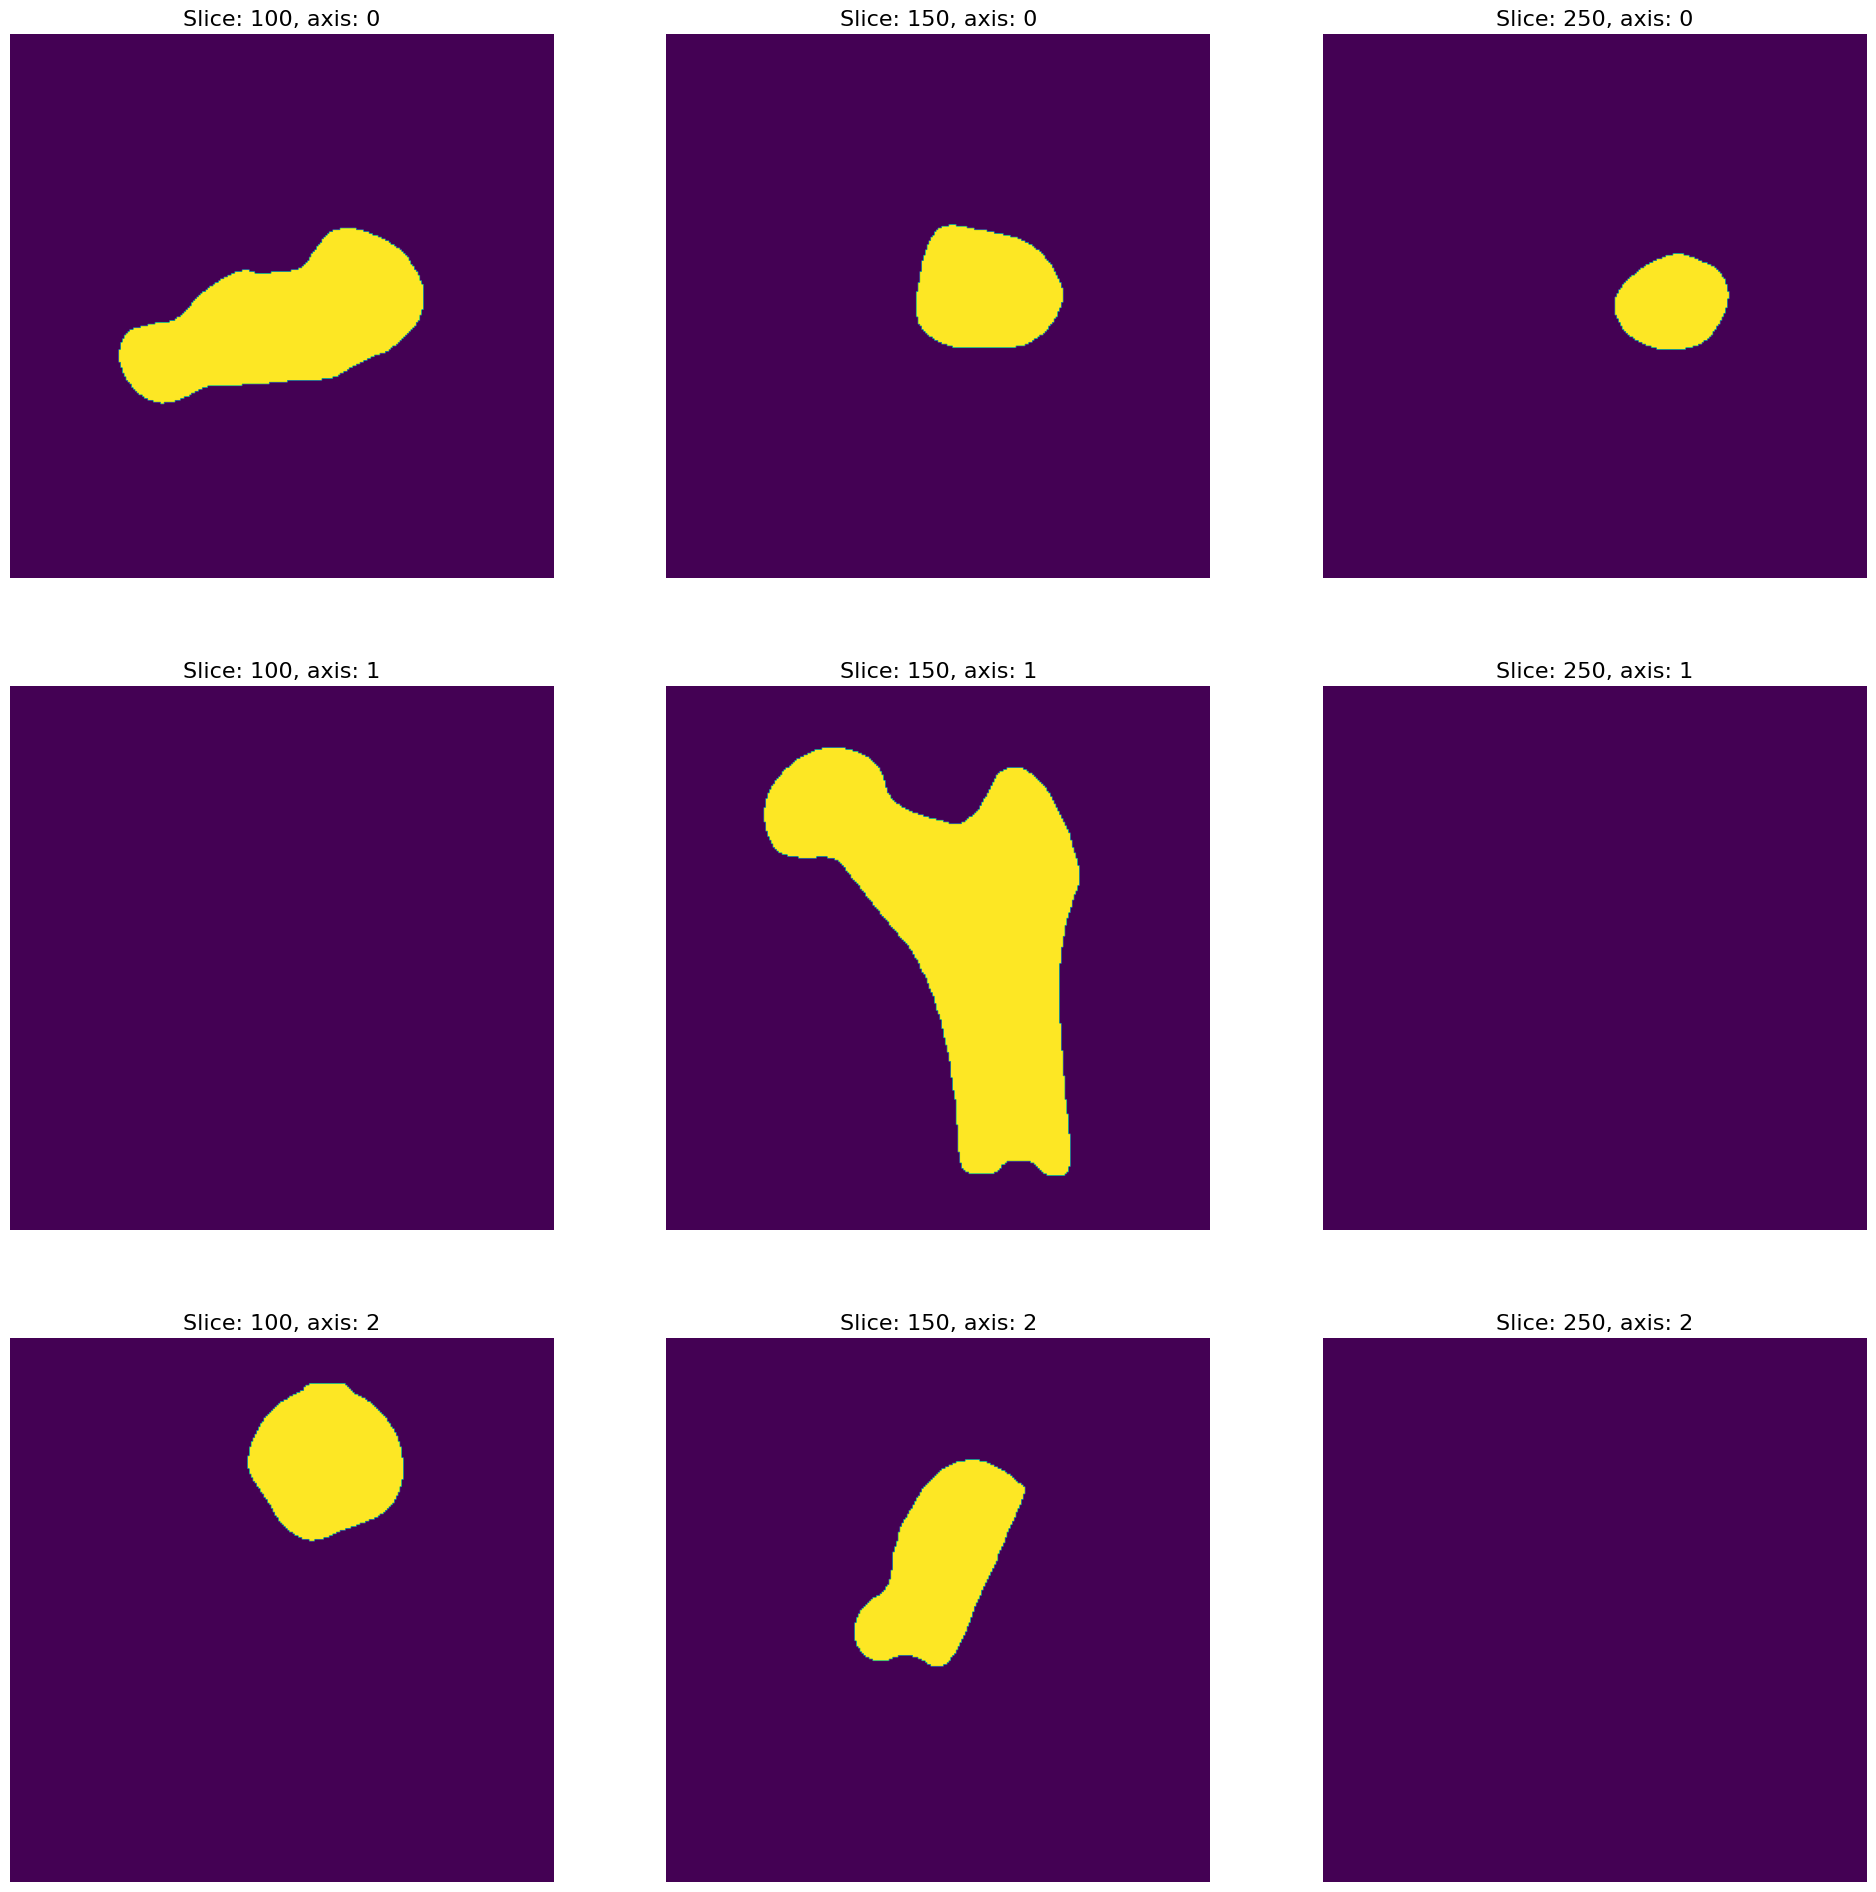

In [23]:
viz_orthogonal_slices(mask_largest, slices, savefig=False)

In [24]:
mask_out = mask_largest.astype(np.uint8)
mask_out = mask_out * 255

In [25]:
output_path = mask_path.replace(".npy", "_mask.tif")
write_tiff(mask_out, output_path)

Saved tiff to: /work3/s173944/Python/projects/segmentation/data/predicted_volumes/Femur_01_80kV_100W_cropped_scale_2_1_mask.tif


In [26]:
scale_factor = 2
mask_upscaled = transform.resize(
        mask_out,
        np.array(mask_out.shape) * scale_factor,
        order=0,  # nearest neighbor
        anti_aliasing=False,
        preserve_range=True
).astype(np.uint8)

output_path = mask_path.replace("_2_1.npy", "_mask.tif")
write_tiff(mask_upscaled, output_path)

Saved tiff to: /work3/s173944/Python/projects/segmentation/data/predicted_volumes/Femur_01_80kV_100W_cropped_scale_mask.tif


Reading input file: /dtu/3d-imaging-center/projects/2025_DANFIX_163_VoDaSuRe/raw_data_extern/Femur_01_80kV/Femur_01_80kV_100W_cropped.tif
tiff shape: (600, 600, 600)


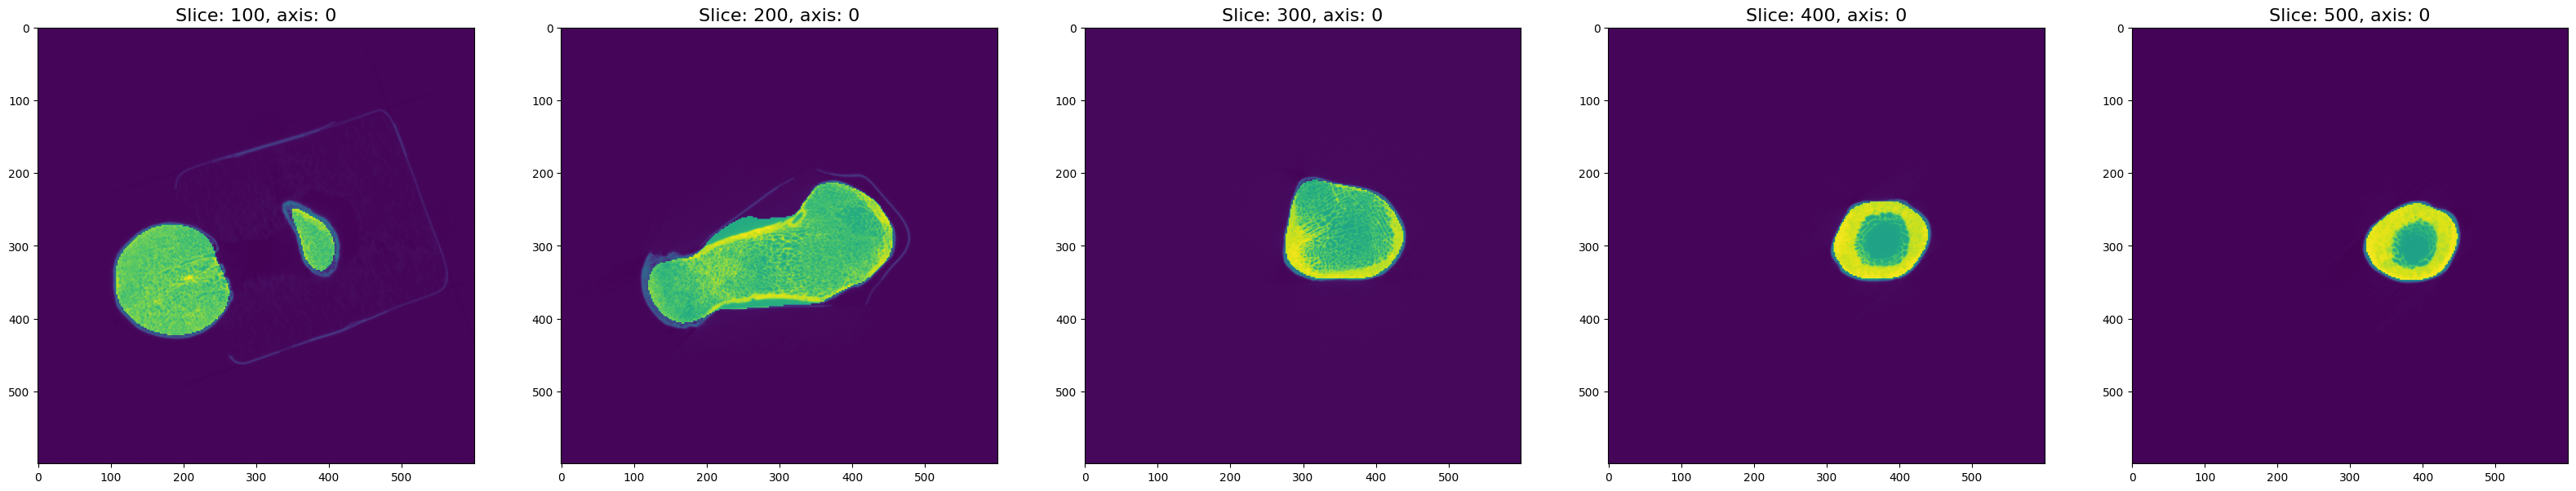

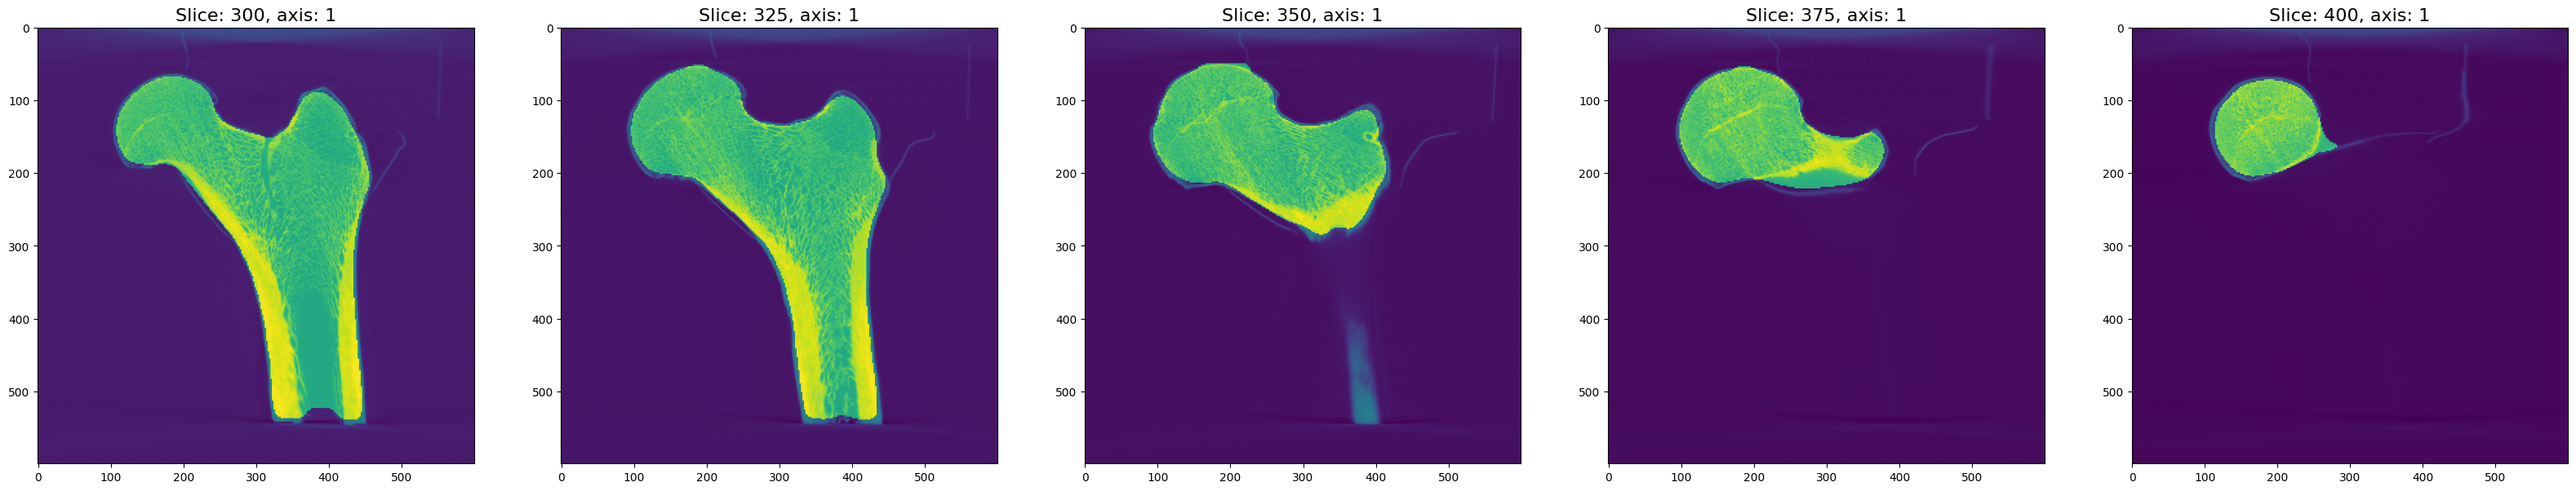

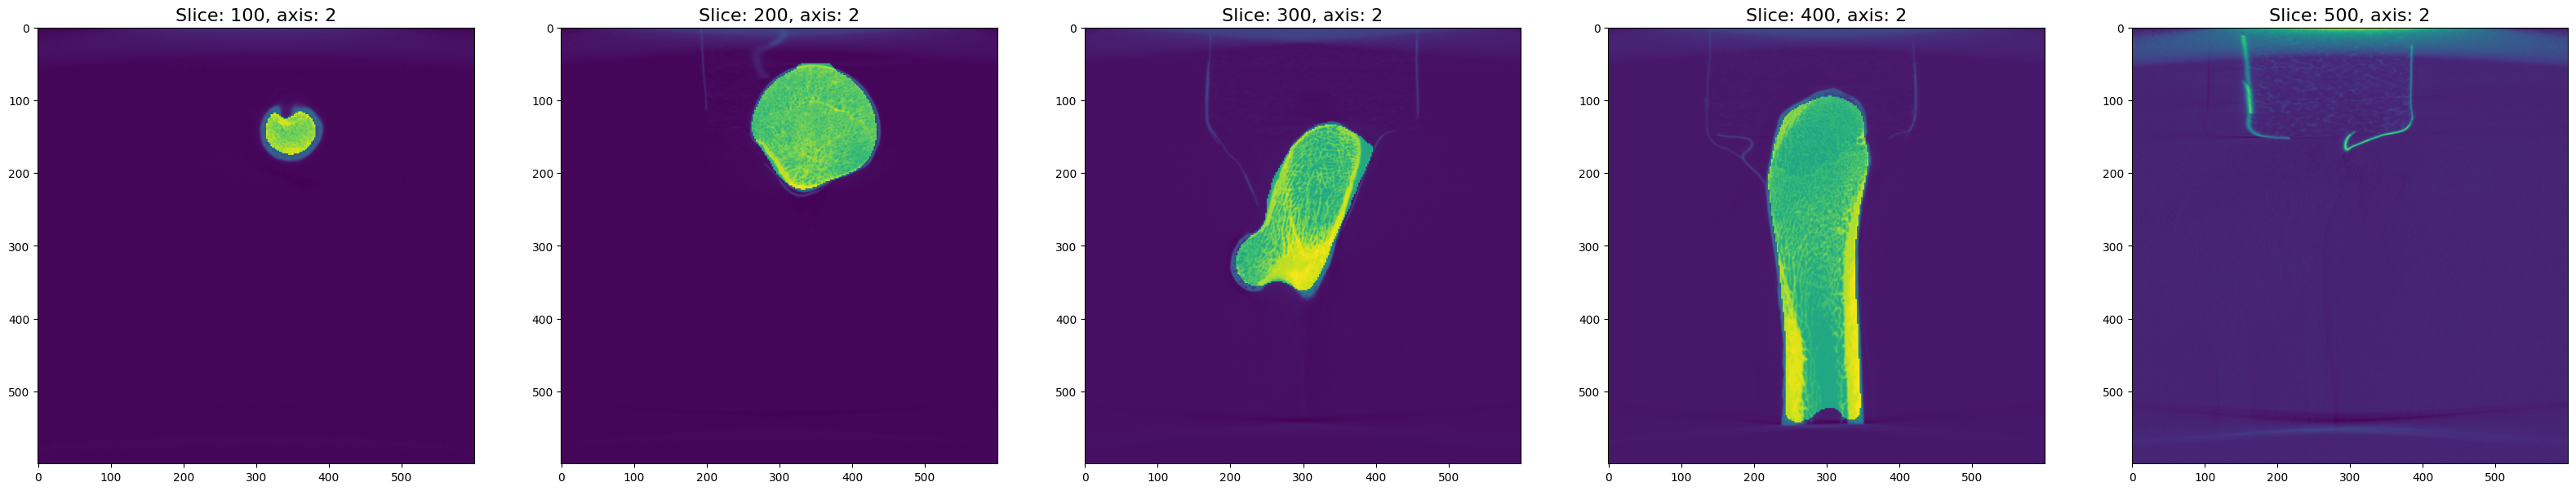

In [31]:

base_path = "/dtu/3d-imaging-center/projects/2025_DANFIX_163_VoDaSuRe/raw_data_extern/Femur_01_80kV/"
image_path = "Femur_01_80kV_100W_cropped.tif"
image_path = os.path.join(base_path, image_path)
img = load_image(image_path)

from utils.utils_preprocess import rescale
img = rescale(img) * 255

viz_slices(mask_upscaled + img, [100, 200, 300, 400, 500], savefig=False, axis=0)

viz_slices(mask_upscaled + img, [300, 325, 350, 375, 400], savefig=False, axis=1)

viz_slices(mask_upscaled + img, [100, 200, 300, 400, 500], savefig=False, axis=2)
